In [2]:
pip install tensorflow tflearn

In [1]:
import tensorflow as tf 

2023-10-14 12:44:46.148885: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 12:44:46.213021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 12:44:46.213087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 12:44:46.213133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 12:44:46.223795: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 12:44:46.226087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
tf.__version__

'2.14.0'

In [3]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-gq28p8p8
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-gq28p8p8
  Resolved https://github.com/tensorflow/docs to commit c6fe18c88c6078bea4f66226f88570e97e0765c6
  Preparing metadata (setup.py) ... done


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
(train_images , test_labels ) , (_,_) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5

In [7]:
Buffer_Size = 6000
Batch_Size = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_Size).batch(Batch_Size)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False , input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,28,28,1)
    
    return model

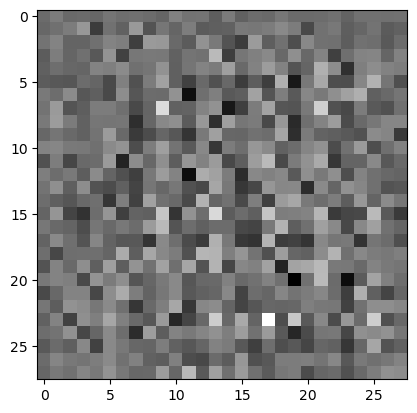

In [10]:
generator = make_generator_model()


noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0] , cmap='gray')

In [11]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,(5,5) , strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5) , strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [12]:
discriminator = make_discriminator_model()
dicision = discriminator(generated_image)
print(dicision)

tf.Tensor([[9.254055e-05]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

In [15]:
def genertor_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [25]:
genretor_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed =tf.random.normal([num_examples_to_generate,noise_dim])

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genretor_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([Batch_Size , noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as Disc_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = genertor_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
        gradients_of_discriminator = Disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        
        genretor_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
        
        

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
            display.clear_output(wait=True)
            generate_and_save_images(generator,epoch + 1 ,seed)
            
            if (epoch + 1) % 15 ==0:
                checkpoint.save(file_prefix=checkpoint_prefix)
                
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
                
            display.clear_output(wait=True)
            generate_and_save_images(generator,epochs,seed)

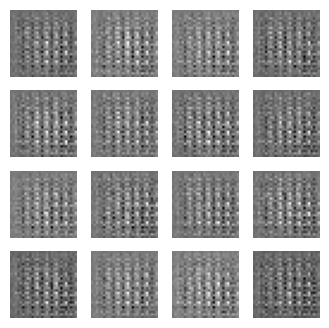

In [ ]:
train(train_dataset,EPOCHS)